# Creating custom datablocks for 3D images and fastai

In [1]:
# export
# default_exp data

import SimpleITK as sitk
import re
import pathlib
import torchvision

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

!ln -s ../faimed3d/ faimed3d

In [2]:
# export
from faimed3d.basics import *
from faimed3d.augment import *


## Get data paths and labels

Data is divided into a train, valid and test dataset of different patients, which either have prostate cancer or are healthy. 
Each patient has three MRI sequences: T2, T1map and ADC. These sequences differ in number of slices and resolution. 

At first the paths to the data are specified: 

In [3]:
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')
test = pathlib.Path('../../dl-prostate-mapping/data/test')

At the moment, I am only interested into the DICOM data, not in the NIfTI segmentations. 

In [4]:
train_files = list(train.rglob('DICOM'))
valid_files = list(valid.rglob('DICOM'))
test_files = list(test.rglob('DICOM'))

To reduce complexity of the data, only the T2 map will be used for the first runs. 

In [5]:
# take only T2 and T1 images for noe
subset_train =[]
for f in train_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_train.append(Path(m.string))
        
subset_valid =[]
for f in valid_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_valid.append(Path(m.string))
        
subset_test = []
for f in test_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_test.append(Path(m.string))

If the patient has prostate cancer or not, can be extracted from the file path. 

In [6]:
labels = ['Gesund', 'ProstataCa']
def label_func(fn): return re.findall(r'(Gesund|ProstataCa)', str(fn))[0]

In [7]:
# export
class ScaleDicom(DisplayedTransform):
    "Transforms a TensorDicom3D volume to float and normalizes the data"
    def __init__(self, div=None, div_mask=1): store_attr()
    
    def encodes(self, x:(TensorDicom3D, TensorMask3D)):
        
        if isinstance(x, TensorMask3D): return x
        
        if self.div is None: 
            return normalize(x.hist_scaled()).float()
        else:
            return (x.hist_scaled()/div).float()
    

In [8]:
# export
def ImageBlock3D(cls=TensorDicom3D):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=ScaleDicom)

## Dataloaders for image classification problems

In [9]:
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              CategoryBlock),
    get_x = lambda x: x,
    get_y = label_func, 
    item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (20, 150, 150), perc_crop = True),
    batch_tfms = [
        *aug_transforms_3d(), 
        RandomCrop3D(((3, 2), (25,25), (25,25)), (0, 25, 25)), 
        PseudoColor],
    splitter = RandomSplitter())

In [10]:
dls = mris.dataloaders(subset_train, 
                       batch_size = 16, 
                       num_workers = 0
                      )
dls.valid.bs = 16 # defaults to 64 and will cause Cuda out of Memory errors

In [11]:
def show_batch_3d(dls, max_n=9, with_mask = False, **kwargs):
    "Workarround, until implemented into dls as dls.show_batch_3d()"
    
    xb, yb = dls.one_batch()
    
    if xb.device.type == 'cuda': xb=xb.cpu()
    if xb.ndim < 4: raise TypeError('Batch is not a batch of multiple 3D images')
    if xb.ndim == 5: 
        print('Expected 4D tensor but got 5D tensor. Removing the last dimension under the assumption that it is a color channel ')
        return show_multiple_3d_images(xb[:,:,:,:,0], **kwargs)
    if xb.ndim > 5: raise NotImplementedError('Batches with more than 3 Dimensions are currently not supported')
    return show_multiple_3d_images(xb, **kwargs)

Expected 4D tensor but got 5D tensor. Removing the last dimension under the assumption that it is a color channel 


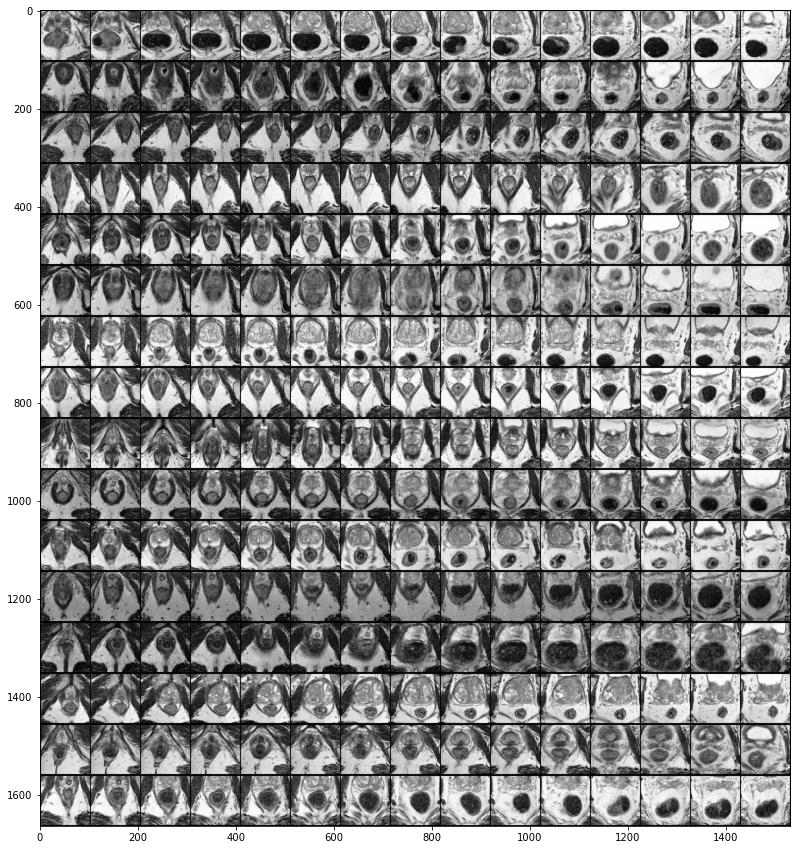

In [12]:
show_batch_3d(dls, axis = 0, nrow = 15)

In [13]:
dls.after_item

Pipeline: ResizeCrop3D -- {'crop_by': (0.0, 0.1, 0.1), 'resize_to': (20, 150, 150), 'perc_crop': True, 'p': 1} -> ToTensor

In [14]:
dls.after_batch

Pipeline: ScaleDicom -- {'div': None, 'div_mask': 1} -> RandomWarp3D -- {'p': 0.1} -> RandomDihedral3D -- {'p': 0.1} -> RandomBrightness3D -- {'p': 0.1} -> RandomContrast3D -- {'p': 0.1} -> RandomNoise3D -- {'p': 0.1} -> RandomRotate3DBy -- {'p': 0.1} -> RandomFlip3D -- {'p': 0.1} -> RandomRotate3D -- {'p': 0.1} -> RandomCrop3D -- {'p': 1} -> PseudoColor -- {'p': 1}

## 3D Segmentation Problem

In [15]:
segmentation_train = [(p.parent/'Annotation').ls()[0] for p in subset_train]

In [16]:
len(subset_train)  == len(segmentation_train)

True

In [17]:
# export 
class AddMaskCodes3D(AddMaskCodes):
    "Add the code metadata to a `TensorMask`"

    def decodes(self, o:TensorMask3D):
        o = o.int()
        if self.codes is not None: o._meta = {'codes': self.codes}
        return o

def MaskBlock3D(codes = None):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=TensorMask3D.create, item_tfms=AddMaskCodes3D(codes=codes),  batch_tfms=ScaleDicom)


In [18]:
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              MaskBlock3D()),
    get_x = lambda x: x[0],
    get_y = lambda x: x[1], 
    item_tfms = (ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (20, 150, 150), perc_crop = True),
                 ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (20, 150, 150), perc_crop = True)),
    batch_tfms = [
        *aug_transforms_3d(p_all=0.1), 
        RandomCrop3D(((3, 2), (25,25), (25,25)), (0, 25, 25)), 
        PseudoColor],
    splitter = RandomSplitter())

In [19]:
d = pd.DataFrame({'x' : subset_train, 
                  'y' : segmentation_train})

In [20]:
dls = mris.dataloaders(d, 
                       batch_size = 10, 
                       num_workers = 0,
                      )
dls.valid.bs = 16 # defaults to 64 and will cause Cuda out of Memory errors

In [40]:
def show_batch_3d(dls, max_n=9, with_mask=False, alpha_mask=0.5, figsize = (15, 15), **kwargs):
    "Workarround, until implemented into dls as dls.show_batch_3d()"
    
    xb, yb = dls.one_batch()
    
    if xb.device.type == 'cuda': 
        xb=xb.cpu()
        yb=yb.cpu()
    if xb.ndim < 4: raise TypeError('Batch is not a batch of multiple 3D images')
    if xb.ndim == 5: 
        print('Expected 4D tensor but got 5D tensor. Removing the last dimension under the assumption that it is a color channel ')
        xb = xb[:,:,:,:,0]
        yb = yb[:,:,:,:,0]
    if xb.ndim > 5: raise NotImplementedError('Batches with more than 3 Dimensions are currently not supported')
        
    if with_mask:
        
        x_grid = show_multiple_3d_images(xb, return_grid = True, **kwargs)
        y_grid = show_multiple_3d_images(yb, return_grid = True, **kwargs) 
        
        plt.figure(figsize=figsize)
        plt.imshow(np.transpose(x_grid, (1,2,0)), cmap = 'bone')
        plt.imshow(np.transpose(y_grid, (1,2,0)), cmap = 'jet', alpha = alpha_mask)

    else: show_multiple_3d_images(xb, **kwargs)
        

In [41]:
show_batch_3d(dls, with_mask=True, nrow = 15,)

ValueError: invalid rotation plane specified

In [ ]:
xb, yb = dls.one_batch()

In [ ]:
xb.shape, yb.shape